# Benchmarking lung integration

In [17]:
import numpy as np
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt

from scib_metrics.benchmark import Benchmarker

## Load and preprocess data

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30)


/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preproces

In [5]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

## Run methods

Here we run:
- Scanorama
- Pyliger
- Harmony
- scVI

Below we sort the anndata so batches are contiguous. This is necessary to run scanorama.

In [6]:
adata = adata[adata.obs.batch.sort_values().index].copy()

In [7]:
%%capture
import scanpy.external as sce
sce.pp.scanorama_integrate(adata, "batch", adjusted_basis="Scanorama")

In [8]:
import pyliger
bdata = adata.copy()
bdata.X = bdata.layers["counts"]
bdata = bdata[:, bdata.var.highly_variable].copy()
# List of adata per batch
batch_cats = bdata.obs.batch.cat.categories
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    ad.uns['var_gene_idx'] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(bdata.obs.batch.cat.categories):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [03:01<00:00,  6.05s/it]


In [9]:
from harmony import harmonize
Z = harmonize(adata.obsm["X_pca"], adata.obs, batch_key = "batch")
adata.obsm["Harmony"] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [10]:
%%capture
import scvi
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


In [11]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "LIGER", "Harmony", "scVI"],
    pre_integrated_embedding_obsm_key="X_pca",
    n_jobs=6,
)
bm.benchmark()


Embeddings: 100%|██████████| 4/4 [01:27<00:00, 21.84s/it]


In [12]:
bm.get_results(min_max_scale=False)

,Isolated labels,Silhouette label,cLISI,Silhouette batch,PCR comparison,iLISI,KBET,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,
Unintegrated,0.464394,0.585415,1.0,0.855258,0.0,0.007811,0.250325,0.278348,0.68327,0.521301
LIGER,0.457692,0.552819,0.986963,0.848981,0.810881,0.158464,0.481633,0.57499,0.665825,0.629491
Harmony,0.468758,0.564016,0.994054,0.87893,0.547319,0.12733,0.466437,0.505004,0.67561,0.607367
scVI,0.533621,0.539027,0.99364,0.89849,0.885143,0.115827,0.362636,0.565524,0.688763,0.639467
Metric Type,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


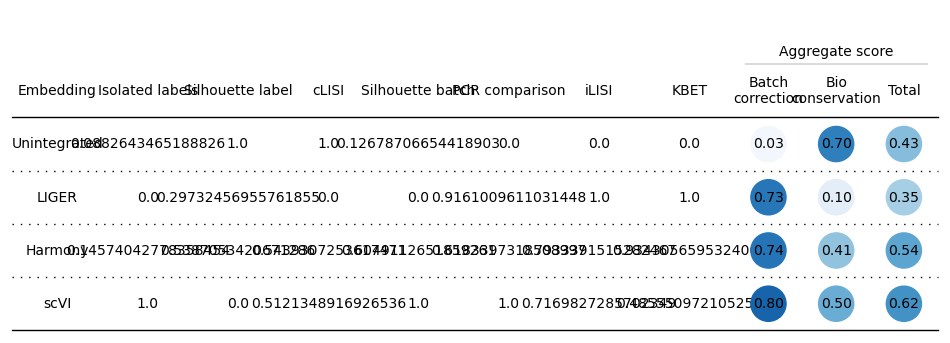

In [27]:
bm.plot_results_table()

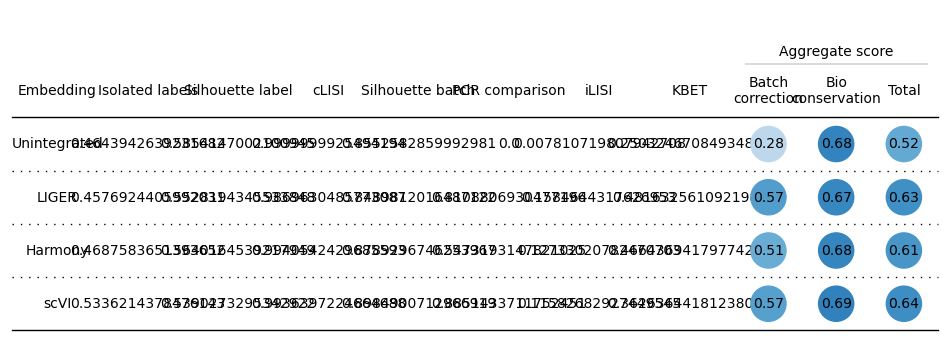

In [28]:
bm.plot_results_table(min_max_scale=False)